# LINKEDIN POSTS ANALYSIS

## Abstract

The obtained data tables in .csv format represent all posts created on a SaaS platform used for Employer Branding activities on LinkedIn. Each table corresponds to a separate client who has an independent instance of the platform. The project's idea is to use the available variables that the user can influence to predict the potential reach of a given post. To achieve this, a regression neural network model was built. It takes the following as input: entered copy, current network, post time, and post type ['LINK' 'NATIVE_GALLERY' 'VIDEO' 'NATIVE_FILE' 'TEXT' 'DOCUMENT'], in order to estimate the actual reach of the post.

Initially, the model was trained on the full spectrum of available data. However, during the learning process, it was decided to exclude posts with a reach exceeding 3,000 to reduce the impact of outliers. As a result, the focus shifted toward building an algorithm that accurately predicts the reach of most posts rather than attempting to account for rare viral outliers. Predicting highly viral posts (reach >3,000) remains challenging due to limited data. Additionally, the model could benefit from further contextual data (e.g., real-world events) to better predict unusually high-reach posts in the future.

When using the full dataset, the mean reach was approximately 1,100, with an unscaled RMSE of around 350. After excluding posts with a reach exceeding 3,000, the mean reach decreased to ~610, and the mean RMSE improved to ~220. This adjustment not only reduced the absolute error but also improved (slightly) the model’s performance in terms of proportional accuracy.

## Library import

In [1]:
#Clearing class
import pandas as pd
from datetime import datetime
import langid

#Data visualization
import matplotlib.pyplot as plt

#Tokenization & embeddings
from transformers import BertTokenizer
from transformers import AutoTokenizer
from transformers import BertModel
from tqdm import tqdm

#Split & scale
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#NN model
import pandas as pd
import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertTokenizer
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

2025-06-18 10:47:15.792066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750243636.004409      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750243636.063163      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print(f"Number of GPUs available: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i} name: {torch.cuda.get_device_name(i)}")

Number of GPUs available: 2
GPU 0 name: Tesla T4
GPU 1 name: Tesla T4


# Data import

In [3]:
still = pd.read_csv("/kaggle/input/data-sets-for-this-project/df_still.csv")
balluf = pd.read_csv("/kaggle/input/data-sets-for-this-project/df_balluf.csv")
orange = pd.read_csv("/kaggle/input/data-sets-for-this-project/df_orange.csv")
capgemini = pd.read_csv("/kaggle/input/data-sets-for-this-project/df_capgemini.csv")
pmi = pd.read_csv("/kaggle/input/data-sets-for-this-project/df_pmi.csv")
bosch = pd.read_csv("/kaggle/input/data-sets-for-this-project/df_bosch.csv")

In [4]:
dfs = {
    "still": still,
    "balluf": balluf,
    "orange": orange,
    "capgemini": capgemini,
    "pmi": pmi,
    "bosch": bosch
}

Note to myself: Created dict to be able to call any frames more easily

In [5]:
for name, df in dfs.items():
    print(f"{name}: {df.shape}")

still: (1329, 17)
balluf: (4892, 17)
orange: (5655, 17)
capgemini: (11924, 16)
pmi: (4456, 17)
bosch: (9798, 17)


In [6]:
for name, df_value in dfs.items():
    if "details_type" in df_value.columns:
        print(f"{name}: {df_value['details_type'].unique()}")
    else:
        print(f"DataFrame '{name}' does not have a 'details_type' column.")

still: ['LINK' 'NATIVE_GALLERY' 'VIDEO' 'NATIVE_FILE' 'TEXT' 'DOCUMENT']
balluf: ['LINK' 'NATIVE_FILE' 'VIDEO' 'NATIVE_GALLERY' 'DOCUMENT' 'TEXT' 'FILE']
orange: ['LINK' 'NATIVE_FILE' 'DOCUMENT' 'NATIVE_GALLERY' 'TEXT' 'VIDEO']
capgemini: ['VIDEO' 'LINK' 'NATIVE_FILE' 'NATIVE_GALLERY' 'DOCUMENT' 'TEXT']
pmi: ['LINK' 'NATIVE_GALLERY' 'NATIVE_FILE' 'DOCUMENT' 'TEXT' 'VIDEO']
bosch: ['TEXT' 'NATIVE_FILE' 'LINK' 'NATIVE_GALLERY' 'DOCUMENT' 'VIDEO' 'JOB']


## Clearing dataframes

In [7]:
class DataProcessor:

    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.df_lang = None
        self.df_pl = None
        self.df_eng = None

    #choose specific columns
    def clean(self):
        required_cols = ["comment", "published_at", "details_type", 
                         "estimated_covearage", "user_network_at_stats_check_date", "language"]
        self.df = self.df[required_cols]
        self.df = self.df.dropna(subset=["estimated_covearage"])

        self.df = self.df.dropna(subset=["comment", "published_at", "details_type", 
                         "estimated_covearage", "user_network_at_stats_check_date"])

        self.df.rename(columns={"estimated_covearage": "reach"}, inplace=True)
        self.df.rename(columns={"user_network_at_stats_check_date": "n_followers"}, inplace=True)
        self.df.rename(columns={"comment": "copy"}, inplace=True)
        self.df.rename(columns={"details_type": "post_format"}, inplace=True)

        allowed_formats = ['LINK', 'NATIVE_GALLERY', 'VIDEO', 'NATIVE_FILE', 'TEXT', 'DOCUMENT']
        
        self.df = self.df[self.df['post_format'].isin(allowed_formats)]
        
    #add translation + "en" label
    def lang_processing(self):

        mask = self.df["language"].isna()
        self.df.loc[mask, "language"] = self.df.loc[mask, "copy"].apply(lambda x: langid.classify(x)[0])
        self.df = self.df[self.df["language"] == "en"]

        self.df = self.df.drop(columns=["language"])

    def hot_encoding(self):

        def map_time_of_day(hour):
            if 6 <= hour < 10:
                return 'morning'
            elif 10 <= hour < 14:
                return 'noon'
            elif 14 <= hour < 18:
                return 'afternoon'
            elif 18 <= hour < 22:
                return 'evening'
            else:
                return 'night'
        
        self.df['published_at'] = pd.to_datetime(self.df['published_at'])

        self.df['post_time'] = self.df['published_at'].dt.hour.apply(lambda x: map_time_of_day(x))

        post_time_one_hot = pd.get_dummies(self.df['post_time'], prefix='post_time').astype(int)

        details_type_one_hot = pd.get_dummies(self.df['post_format'], prefix='post_format').astype(int)

        self.df = pd.concat([self.df, post_time_one_hot, details_type_one_hot], axis=1)
        
        self.df = self.df.drop(columns=['published_at', 'post_time', 'post_format'])

    def float_to_int(self):

        cols_to_cast = ["reach", "n_followers"]

        for col in cols_to_cast:
            self.df[col] = self.df[col].apply(lambda x: int(x))

    def reset(self):
        
        self.df.reset_index(drop=True, inplace=True)

    def process_all(self):
        
        self.clean()  
        self.lang_processing()
        self.hot_encoding()
        self.float_to_int()
        self.reset()

        
        return self.df

In [8]:
processed_dfs = {}

for name, df in dfs.items():
    processor = DataProcessor(df)
    processed_df = processor.process_all()
    processed_dfs[name] = processed_df

In [9]:
for name, df in processed_dfs.items():
    print(f"{name}: {df.shape}")

still: (3, 7)
balluf: (2752, 14)
orange: (65, 10)
capgemini: (5597, 14)
pmi: (2536, 14)
bosch: (3899, 14)


In [10]:
selected_keys = ["pmi", "bosch", "balluf", "capgemini"]
dfs = {key: processed_dfs[key] for key in selected_keys}

## Sanity check if datasets have same number of columns

In [11]:
for name, df in dfs.items():
    print(f"{name}: {df.shape}")

pmi: (2536, 14)
bosch: (3899, 14)
balluf: (2752, 14)
capgemini: (5597, 14)


## Final check if there are any empty or NaN cells 

In [12]:
for name, df in dfs.items():
    mask = df.isna() | (df == "")
    rows_with_empty_or_nan = mask.any(axis=1)
    count = rows_with_empty_or_nan.sum()
    print(f"{name}: {count} rows have NaN or empty string")

pmi: 0 rows have NaN or empty string
bosch: 0 rows have NaN or empty string
balluf: 0 rows have NaN or empty string
capgemini: 0 rows have NaN or empty string


# Tokenization

In [43]:
balluf = dfs["balluf"]
capgemini = dfs["capgemini"]
pmi = dfs["pmi"]
bosch = dfs["bosch"]

combined_df = pd.concat([dfs["balluf"], dfs["capgemini"], dfs["pmi"], dfs["bosch"]], axis=0)
combined_df = combined_df.reset_index(drop=True)

combined_df = combined_df[combined_df['reach'] <= 3000] ### decided to cut off the rest


,copy,reach,n_followers,post_time_afternoon,post_time_evening,post_time_morning,post_time_night,post_time_noon,post_format_DOCUMENT,post_format_LINK,post_format_NATIVE_FILE,post_format_NATIVE_GALLERY,post_format_TEXT,post_format_VIDEO
0,Identification and tracking of cell boxes made...,588,1251,1,0,0,0,0,0,1,0,0,0,0
1,NEW PRODUCT // Industrial machine vision has c...,463,1251,1,0,0,0,0,0,1,0,0,0,0
2,INNOVATING AUTOMATION // We know goals are rar...,588,1251,1,0,0,0,0,0,1,0,0,0,0
3,INNOVATING AUTOMATION // We know that good tea...,538,1251,1,0,0,0,0,0,1,0,0,0,0
4,INNOVATING AUTOMATION // To all the condition-...,713,1251,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14779,🚀 Shape the digital future with Bosch! 🚀 Are ...,634,1528,0,0,1,0,0,0,1,0,0,0,0
14780,🚀 Shape the digital future with Bosch! 🚀 Are ...,87,178,0,0,0,0,1,0,1,0,0,0,0
14781,🚀 Shape the digital future with Bosch! 🚀 Are ...,182,520,0,0,0,0,1,0,1,0,0,0,0
14782,Finishing work has never been easier! 🏠✨ The ...,106,232,0,0,0,0,1,0,1,0,0,0,0


In [44]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tqdm.pandas()

def tokenize_text(text):
    return tokenizer(
        text,
        padding=True,     
        truncation=True,
        max_length=512,
        return_tensors="pt"        
    )

combined_df['tokens'] = combined_df['copy'].progress_apply(tokenize_text)

100%|██████████| 13991/13991 [00:37<00:00, 376.02it/s]


Note to myself: Used "uncased" model here to lower the amount of time to run code

# Embeddings

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [46]:
model = BertModel.from_pretrained('bert-base-uncased')
model.to(device)
model.eval()

torch.set_grad_enabled(False)

embeddings = []

for token_dict in tqdm(combined_df["tokens"], desc="Generating embeddings"):
    input_ids = token_dict['input_ids'].to(device)
    token_type_ids = token_dict['token_type_ids'].to(device)
    attention_mask = token_dict['attention_mask'].to(device)

    outputs = model(input_ids=input_ids,
                    token_type_ids=token_type_ids,
                    attention_mask=attention_mask)

    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0).detach().cpu()
    embeddings.append(cls_embedding)

Generating embeddings: 100%|██████████| 13991/13991 [03:33<00:00, 65.42it/s]


Note to myself: Here I turned off grading, which makes impossible adding grading later if not turned on.

In [47]:
combined_df["embeddings"] = embeddings

In [48]:
all_shapes = [e.shape for e in combined_df["embeddings"]]
print(set(all_shapes))

{torch.Size([768])}


In [49]:
print(combined_df["embeddings"][0].dtype)     # should be torch.float32
print(combined_df["embeddings"][0].device)

torch.float32
cpu


In [50]:
combined_df.columns.tolist()

['copy',
 'reach',
 'n_followers',
 'post_time_afternoon',
 'post_time_evening',
 'post_time_morning',
 'post_time_night',
 'post_time_noon',
 'post_format_DOCUMENT',
 'post_format_LINK',
 'post_format_NATIVE_FILE',
 'post_format_NATIVE_GALLERY',
 'post_format_TEXT',
 'post_format_VIDEO',
 'tokens',
 'embeddings']

In [51]:
n_followers = torch.tensor(combined_df['n_followers'].values).unsqueeze(1).float()
reach = torch.tensor(combined_df['reach'].values).unsqueeze(1).float()

post_time_columns = ['post_time_afternoon', 'post_time_evening', 'post_time_morning', 'post_time_night', 'post_time_noon']

post_time = torch.tensor(combined_df[post_time_columns].values) 

formats_columns = ['post_format_DOCUMENT', 'post_format_LINK', 'post_format_NATIVE_FILE', 
                   'post_format_NATIVE_GALLERY', 'post_format_TEXT', 'post_format_VIDEO']

formats = torch.tensor(combined_df[formats_columns].values)

embeddings = torch.stack(combined_df['embeddings'].values.tolist()) 

## Final size check

In [52]:
print(n_followers.size())
print(post_time.size())
print(formats.size())
print(embeddings.size())
print(reach.size())

torch.Size([13991, 1])
torch.Size([13991, 5])
torch.Size([13991, 6])
torch.Size([13991, 768])
torch.Size([13991, 1])


## Concat them together

In [53]:
X = torch.cat([n_followers, post_time, formats, embeddings], dim=1)
y = reach

In [54]:
print(X.size())
print(y.size())

torch.Size([13991, 780])
torch.Size([13991, 1])


# Train/val/test split

In [55]:
X_np = X.numpy()
y_np = y.numpy()

In [56]:
# First split: train (70%) vs temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X_np, y_np, test_size=0.3, random_state=42)

# Second split: val (15%) vs test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Standard Scaler

In [57]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_val_scaled = scaler_x.transform(X_val)
X_test_scaled = scaler_x.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

## Back to tensors

In [58]:
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train = torch.tensor(y_train_scaled, dtype=torch.float32)
y_val = torch.tensor(y_val_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32)

# Data visualization

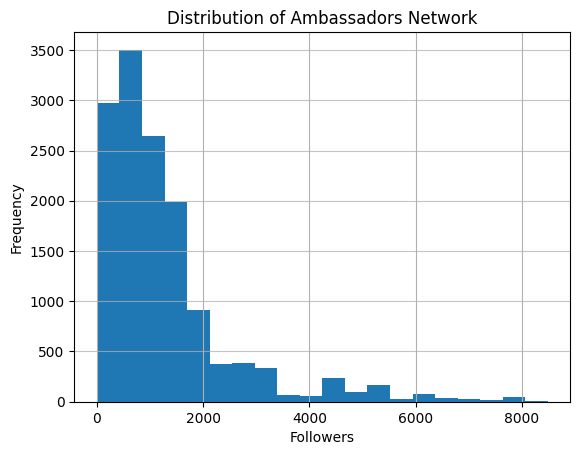

1280.7836466299764


In [59]:
combined_df['n_followers'].hist(bins=20)
plt.title('Distribution of Ambassadors Network')
plt.xlabel('Followers')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

print(combined_df["n_followers"].mean())

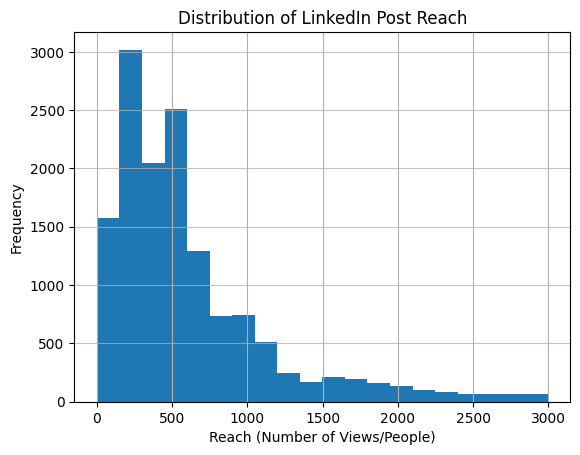

611.0094346365521


In [60]:
combined_df['reach'].hist(bins=20)
plt.title('Distribution of LinkedIn Post Reach')
plt.xlabel('Reach (Number of Views/People)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

print(combined_df["reach"].mean())

Conclusion - "reach" and "n_followers" are heavily skewed to right. Which means the log-transformation could be used here, but when applied - RMSE in every model was doubled.

## Sanity check if they are correctly split 

In [61]:
print(X_train.size())
print(X_val.size())
print(X_test.size())

print(X.size())

torch.Size([9793, 780])
torch.Size([2099, 780])
torch.Size([2099, 780])
torch.Size([13991, 780])


# Neural network

In [62]:
torch.set_grad_enabled(True)

Note to myself: Have to remeber to enable grad everytime before feeding models. It was turned off by BertModel and caused lot of problems

In [78]:
X_train = X_train.to(device) 
y_train = y_train.to(device) 
X_val = X_val.to(device)     
y_val = y_val.to(device)     

Note to myself: In order to use GPU everything has to be placed on the device

In [63]:
class Model(nn.Module):
    def __init__(self, in_features=780, h1=8, h2=6, output=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, output)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [64]:
class FlexibleModel(nn.Module):
    def __init__(self, in_features, hidden_layers_sizes, output_size=1, dropout_prob=0.5):
        super().__init__()
        self.layers = nn.ModuleList() 
        self.dropouts = nn.ModuleList()

        current_in_features = in_features 

        for h_size in hidden_layers_sizes:
            self.layers.append(nn.Linear(current_in_features, h_size))
            self.dropouts.append(nn.Dropout(dropout_prob)) 
            current_in_features = h_size

        self.out = nn.Linear(current_in_features, output_size)

    def forward(self, x):
        for layer, dropout in zip(self.layers, self.dropouts):
            x = F.relu(layer(x))  
            x = dropout(x)        
        x = self.out(x)           
        return x

Note to myself: To create NN model, it has to include: 
1. __init__ contructor with chosen features, then goes every layer which has to match with previous + out layer
2. def foward which consists of layer activators
3. in order to make the model more flexible it has to include for loop in order to create x layers

### NN MODELS

## Simple model

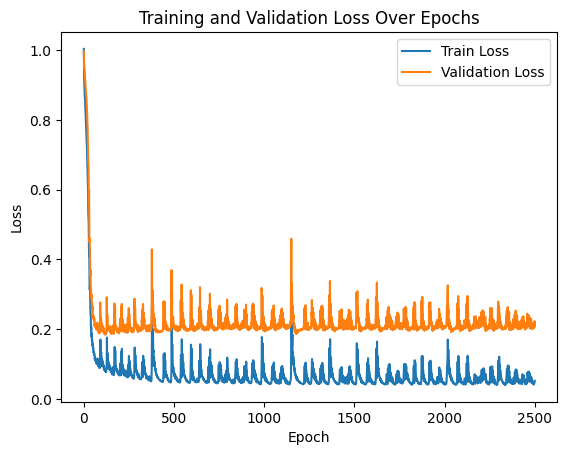

Overall MSE on the train set: 17679.8301
Overall MSE on the validation set: 61105.4805
Overall RMSE on the validation set: 247


In [189]:
num_epochs = 2500
loss_list = []
val_loss_list = []

model_nn = Model(in_features=780)
optimizer = torch.optim.Adam(model_nn.parameters(), lr=0.01, weight_decay=0.01)
criterion = nn.MSELoss()

model_nn = nn.DataParallel(model_nn)
model_nn.to(device)

for epoch in range(num_epochs):
    model_nn.train()

    # Forward pass
    y_pred = model_nn(X_train)
    loss = F.mse_loss(y_pred, y_train)

    # Backward + optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())

    # Validation
    model_nn.eval()
    with torch.no_grad():
        val_pred = model_nn(X_val)
        val_loss = F.mse_loss(val_pred, y_val)
        val_loss_list.append(val_loss.item())

plt.plot(loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

model_nn.eval()
with torch.no_grad():

    overall_train_pred_scaled = model_nn(X_train)
    overall_val_pred_scaled = model_nn(X_val)

    overall_train_pred_unscaled_np = scaler_y.inverse_transform(overall_train_pred_scaled.detach().cpu().numpy())
    overall_val_pred_unscaled_np = scaler_y.inverse_transform(overall_val_pred_scaled.detach().cpu().numpy())

    
    y_train_unscaled_np = scaler_y.inverse_transform(y_train.detach().cpu().numpy())
    y_val_unscaled_np = scaler_y.inverse_transform(y_val.detach().cpu().numpy())

    overall_mse_train_unscaled = np.mean((overall_train_pred_unscaled_np - y_train_unscaled_np)**2)
    overall_mse_val_unscaled = np.mean((overall_val_pred_unscaled_np - y_val_unscaled_np)**2)

    overall_rmse_val_unscaled = np.sqrt(overall_mse_val_unscaled)


print(f"Overall MSE on the train set: {overall_mse_train_unscaled.item():.4f}")
print(f"Overall MSE on the validation set: {overall_mse_val_unscaled.item():.4f}")
print(f"Overall RMSE on the validation set: {overall_rmse_val_unscaled.item():.0f}")

## Config model 1

Model 1:


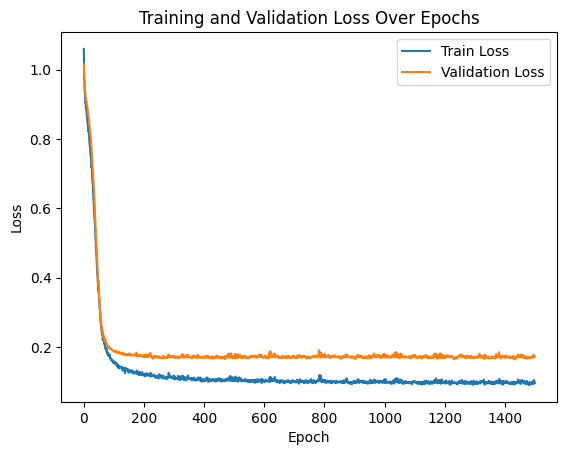

Scaled MSE on train set: 0.0418
Scaled MSE on validation set: 0.1723
Unscaled RMSE on validation set: 222


In [131]:
hidden_config_1 = [128, 64]
model_1 = FlexibleModel(in_features=780, hidden_layers_sizes=hidden_config_1, dropout_prob=0.5)
print("Model 1:")

optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.001, weight_decay=0.01)

model_1 = nn.DataParallel(model_1)
model_1.to(device)

num_epochs = 1500
loss_list1 = []
val_loss_list1 = []

for epoch in range(num_epochs):
    model_1.train()

    # Forward pass
    y_pred = model_1(X_train)
    loss = F.mse_loss(y_pred, y_train)

    # Backward + optimize
    optimizer_1.zero_grad()
    loss.backward()
    optimizer_1.step()

    loss_list1.append(loss.item())

    # Validation
    model_1.eval()
    with torch.no_grad():
        val_pred = model_1(X_val)
        val_loss = F.mse_loss(val_pred, y_val)
        val_loss_list1.append(val_loss.item())

plt.plot(loss_list1, label='Train Loss')
plt.plot(val_loss_list1, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

model_1.eval()
with torch.no_grad():
    # Get scaled predictions
    overall_train_pred_scaled = model_1(X_train)
    overall_val_pred_scaled = model_1(X_val)
    
    # Calculate scaled MSE (0-1 range)
    scaled_mse_train = F.mse_loss(overall_train_pred_scaled, y_train).item()
    scaled_mse_val = F.mse_loss(overall_val_pred_scaled, y_val).item()

    train_pred_unscaled = scaler_y.inverse_transform(overall_train_pred_scaled.detach().cpu().numpy())
    val_pred_unscaled = scaler_y.inverse_transform(overall_val_pred_scaled.detach().cpu().numpy())
    
    # Then inverse transform the true values
    y_train_unscaled = scaler_y.inverse_transform(y_train.detach().cpu().numpy())
    y_val_unscaled = scaler_y.inverse_transform(y_val.detach().cpu().numpy())

    # Now calculate MSE on original scale
    mse_train_unscaled = np.mean((train_pred_unscaled - y_train_unscaled)**2)
    mse_val_unscaled = np.mean((val_pred_unscaled - y_val_unscaled)**2)

    rmse_val_unscaled = np.sqrt(mse_val_unscaled)


print(f"Scaled MSE on train set: {scaled_mse_train:.4f}")  
print(f"Scaled MSE on validation set: {scaled_mse_val:.4f}") 
print(f"Unscaled RMSE on validation set: {rmse_val_unscaled.item():.0f}")

In [129]:
weight_decay_values = [0.0, 0.01, 0.001, 0.005, 0.008]
dropout_prob = [0.3, 0.5, 0.6, 0.7]

results = {}

for do_val in dropout_prob:
    for wd_val in weight_decay_values:
        
        hyperparams_key = f"WD={wd_val}, DO={do_val}"
        print(f"\n--- Training with: {hyperparams_key} ---")
    
        model_1 = FlexibleModel(in_features=780, hidden_layers_sizes=hidden_config_1, dropout_prob=do_val)
    
        optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.001, weight_decay=wd_val)
    
        model_1.to(device)
    
        num_epochs = 1500
        loss_list1 = []
        val_loss_list1 = []
        
        for epoch in range(num_epochs):
            model_1.train()
        
            # Forward pass
            y_pred = model_1(X_train)
            loss = F.mse_loss(y_pred, y_train)
        
            # Backward + optimize
            optimizer_1.zero_grad()
            loss.backward()
            optimizer_1.step()
        
            loss_list1.append(loss.item())
        
            # Validation
            model_1.eval()
            with torch.no_grad():
                val_pred = model_1(X_val)
                val_loss = F.mse_loss(val_pred, y_val)
                val_loss_list1.append(val_loss.item())
    
        final_val_loss = val_loss_list1[-1]
        results[hyperparams_key] = final_val_loss
        
        print(f"    Finished. Final Validation MSE: {final_val_loss:.6f}")

print("\n--- Grid Search Complete ---")

best_hyperparams = min(results, key=results.get)
best_loss = results[best_hyperparams]

print(f"\nBest Hyperparameters found: {best_hyperparams}")
print(f"Corresponding final validation MSE: {best_loss:.6f}")


--- Training with: WD=0.0, DO=0.3 ---
    Finished. Final Validation MSE: 0.192096

--- Training with: WD=0.01, DO=0.3 ---
    Finished. Final Validation MSE: 0.164718

--- Training with: WD=0.001, DO=0.3 ---
    Finished. Final Validation MSE: 0.174927

--- Training with: WD=0.005, DO=0.3 ---
    Finished. Final Validation MSE: 0.168768

--- Training with: WD=0.008, DO=0.3 ---
    Finished. Final Validation MSE: 0.166949

--- Training with: WD=0.0, DO=0.5 ---
    Finished. Final Validation MSE: 0.191879

--- Training with: WD=0.01, DO=0.5 ---
    Finished. Final Validation MSE: 0.172850

--- Training with: WD=0.001, DO=0.5 ---
    Finished. Final Validation MSE: 0.181419

--- Training with: WD=0.005, DO=0.5 ---
    Finished. Final Validation MSE: 0.169297

--- Training with: WD=0.008, DO=0.5 ---
    Finished. Final Validation MSE: 0.168347

--- Training with: WD=0.0, DO=0.6 ---
    Finished. Final Validation MSE: 0.194458

--- Training with: WD=0.01, DO=0.6 ---
    Finished. Final Va

## Config model 2

Model 2:


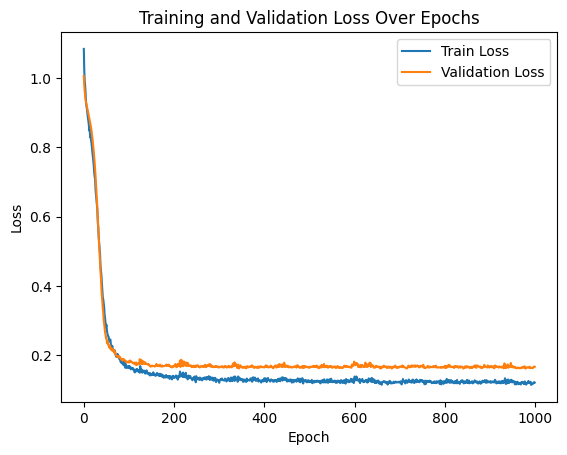

Scaled MSE on train set: 0.0519
Scaled MSE on validation set: 0.1669
Unscaled RMSE on validation set: 219


In [134]:
hidden_config_2 = [256, 128]
model_2 = FlexibleModel(in_features=780, hidden_layers_sizes=hidden_config_2, dropout_prob=0.7)
print("Model 2:")

optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.001, weight_decay=0.01)

model_2 = nn.DataParallel(model_2)
model_2.to(device)

num_epochs = 1000
loss_list2 = []
val_loss_list2 = []

for epoch in range(num_epochs):
    model_2.train()

    # Forward pass
    y_pred = model_2(X_train)
    loss = F.mse_loss(y_pred, y_train)

    # Backward + optimize
    optimizer_2.zero_grad()
    loss.backward()
    optimizer_2.step()

    loss_list2.append(loss.item())

    # Validation
    model_2.eval()
    with torch.no_grad():
        val_pred = model_2(X_val)
        val_loss = F.mse_loss(val_pred, y_val)
        val_loss_list2.append(val_loss.item())

plt.plot(loss_list2, label='Train Loss')
plt.plot(val_loss_list2, label='Validation Loss') 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

model_2.eval()

with torch.no_grad():
    # Get scaled predictions
    overall_train_pred_scaled = model_2(X_train)
    overall_val_pred_scaled = model_2(X_val)
    
    # Calculate scaled MSE (0-1 range)
    scaled_mse_train = F.mse_loss(overall_train_pred_scaled, y_train).item()
    scaled_mse_val = F.mse_loss(overall_val_pred_scaled, y_val).item()

    train_pred_unscaled = scaler_y.inverse_transform(overall_train_pred_scaled.detach().cpu().numpy())
    val_pred_unscaled = scaler_y.inverse_transform(overall_val_pred_scaled.detach().cpu().numpy())
    
    # Then inverse transform the true values
    y_train_unscaled = scaler_y.inverse_transform(y_train.detach().cpu().numpy())
    y_val_unscaled = scaler_y.inverse_transform(y_val.detach().cpu().numpy())

    # Now calculate MSE on original scale
    mse_train_unscaled = np.mean((train_pred_unscaled - y_train_unscaled)**2)
    mse_val_unscaled = np.mean((val_pred_unscaled - y_val_unscaled)**2)

    rmse_val_unscaled = np.sqrt(mse_val_unscaled)


print(f"Scaled MSE on train set: {scaled_mse_train:.4f}")  
print(f"Scaled MSE on validation set: {scaled_mse_val:.4f}")  
print(f"Unscaled RMSE on validation set: {rmse_val_unscaled.item():.0f}")

In [119]:
weight_decay_values = [0.0, 0.01, 0.001, 0.005, 0.008]
dropout_prob = [0.3, 0.5, 0.6, 0.7]

results = {}

for do_val in dropout_prob:
    for wd_val in weight_decay_values:
        
        hyperparams_key = f"WD={wd_val}, DO={do_val}"
        print(f"\n--- Training with: {hyperparams_key} ---")
    
        model_2 = FlexibleModel(in_features=780, hidden_layers_sizes=hidden_config_2, dropout_prob=do_val)
    
        optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.001, weight_decay=wd_val)
    
        model_2.to(device)
    
        num_epochs = 1000
        loss_list2 = []
        val_loss_list2 = []
        
        for epoch in range(num_epochs):
            model_2.train()
        
            # Forward pass
            y_pred = model_2(X_train)
            loss = F.mse_loss(y_pred, y_train)
        
            # Backward + optimize
            optimizer_2.zero_grad()
            loss.backward()
            optimizer_2.step()
        
            loss_list2.append(loss.item())
        
            # Validation
            model_2.eval()
            with torch.no_grad():
                val_pred = model_2(X_val)
                val_loss = F.mse_loss(val_pred, y_val)
                val_loss_list2.append(val_loss.item())
    
        final_val_loss = val_loss_list2[-1]
        results[hyperparams_key] = final_val_loss
        
        print(f"    Finished. Final Validation MSE: {final_val_loss:.6f}")

print("\n--- Grid Search Complete ---")

best_hyperparams = min(results, key=results.get)
best_loss = results[best_hyperparams]

print(f"\nBest Hyperparameters found: {best_hyperparams}")
print(f"Corresponding final validation MSE: {best_loss:.6f}")


--- Training with: WD=0.0, DO=0.3 ---
    Finished. Final Validation MSE: 0.181374

--- Training with: WD=0.01, DO=0.3 ---
    Finished. Final Validation MSE: 0.166789

--- Training with: WD=0.001, DO=0.3 ---
    Finished. Final Validation MSE: 0.172366

--- Training with: WD=0.005, DO=0.3 ---
    Finished. Final Validation MSE: 0.166701

--- Training with: WD=0.008, DO=0.3 ---
    Finished. Final Validation MSE: 0.183056

--- Training with: WD=0.0, DO=0.5 ---
    Finished. Final Validation MSE: 0.185778

--- Training with: WD=0.01, DO=0.5 ---
    Finished. Final Validation MSE: 0.169503

--- Training with: WD=0.001, DO=0.5 ---
    Finished. Final Validation MSE: 0.172843

--- Training with: WD=0.005, DO=0.5 ---
    Finished. Final Validation MSE: 0.161781

--- Training with: WD=0.008, DO=0.5 ---
    Finished. Final Validation MSE: 0.166578

--- Training with: WD=0.0, DO=0.6 ---
    Finished. Final Validation MSE: 0.183806

--- Training with: WD=0.01, DO=0.6 ---
    Finished. Final Va

## Config model 3

Model 3:


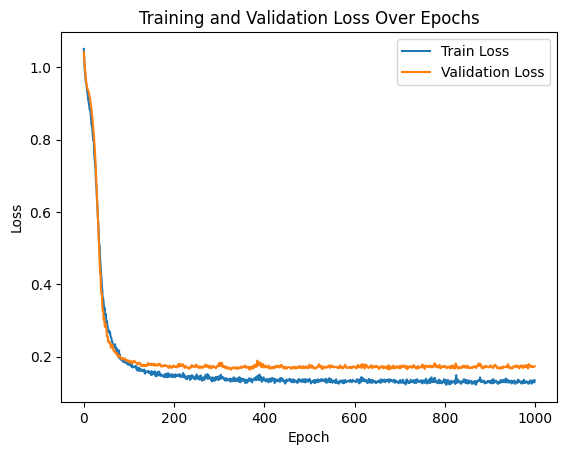

Scaled MSE on train set: 0.0483
Scaled MSE on validation set: 0.1735
Unscaled RMSE on validation set: 223


In [168]:
hidden_config_3 = [256, 128, 64]
model_3 = FlexibleModel(in_features=780, hidden_layers_sizes=hidden_config_3, dropout_prob=0.6)
print("Model 3:")

optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=0.001, weight_decay=0.008)

model_3 = nn.DataParallel(model_3)
model_3.to(device)

num_epochs = 1000
loss_list3 = []
val_loss_list3 = []

for epoch in range(num_epochs):
    model_3.train()

    # Forward pass
    y_pred = model_3(X_train)
    loss = F.mse_loss(y_pred, y_train)

    # Backward + optimize
    optimizer_3.zero_grad()
    loss.backward()
    optimizer_3.step()

    loss_list3.append(loss.item())

    # Validation
    model_3.eval()
    with torch.no_grad():
        val_pred = model_3(X_val)
        val_loss = F.mse_loss(val_pred, y_val)
        val_loss_list3.append(val_loss.item())

plt.plot(loss_list3, label='Train Loss')
plt.plot(val_loss_list3, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

model_3.eval() 
with torch.no_grad():
    # Get scaled predictions
    overall_train_pred_scaled = model_3(X_train)
    overall_val_pred_scaled = model_3(X_val)
    
    # Calculate scaled MSE (0-1 range)
    scaled_mse_train = F.mse_loss(overall_train_pred_scaled, y_train).item()
    scaled_mse_val = F.mse_loss(overall_val_pred_scaled, y_val).item()

    train_pred_unscaled = scaler_y.inverse_transform(overall_train_pred_scaled.detach().cpu().numpy())
    val_pred_unscaled = scaler_y.inverse_transform(overall_val_pred_scaled.detach().cpu().numpy())
    
    # Then inverse transform the true values
    y_train_unscaled = scaler_y.inverse_transform(y_train.detach().cpu().numpy())
    y_val_unscaled = scaler_y.inverse_transform(y_val.detach().cpu().numpy())

    # Now calculate MSE on original scale
    mse_train_unscaled = np.mean((train_pred_unscaled - y_train_unscaled)**2)
    mse_val_unscaled = np.mean((val_pred_unscaled - y_val_unscaled)**2)

    rmse_val_unscaled = np.sqrt(mse_val_unscaled)


print(f"Scaled MSE on train set: {scaled_mse_train:.4f}")  
print(f"Scaled MSE on validation set: {scaled_mse_val:.4f}")  
print(f"Unscaled RMSE on validation set: {rmse_val_unscaled.item():.0f}")

In [135]:
weight_decay_values = [0.0, 0.01, 0.001, 0.005, 0.008]
dropout_prob = [0.3, 0.5, 0.6, 0.7]

results = {}

for do_val in dropout_prob:
    for wd_val in weight_decay_values:
        
        hyperparams_key = f"WD={wd_val}, DO={do_val}"
        print(f"\n--- Training with: {hyperparams_key} ---")
    
        model_3 = FlexibleModel(in_features=780, hidden_layers_sizes=hidden_config_3, dropout_prob=do_val)
    
        optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=0.001, weight_decay=wd_val)
    
        model_3.to(device)
    
        num_epochs = 1000
        loss_list3 = []
        val_loss_list3 = []
        
        for epoch in range(num_epochs):
            model_3.train()
        
            # Forward pass
            y_pred = model_3(X_train)
            loss = F.mse_loss(y_pred, y_train)
        
            # Backward + optimize
            optimizer_3.zero_grad()
            loss.backward()
            optimizer_3.step()
        
            loss_list3.append(loss.item())
        
            # Validation
            model_3.eval()
            with torch.no_grad():
                val_pred = model_3(X_val)
                val_loss = F.mse_loss(val_pred, y_val)
                val_loss_list3.append(val_loss.item())
    
        final_val_loss = val_loss_list3[-1]
        results[hyperparams_key] = final_val_loss
        
        print(f"    Finished. Final Validation MSE: {final_val_loss:.6f}")

print("\n--- Grid Search Complete ---")

best_hyperparams = min(results, key=results.get)
best_loss = results[best_hyperparams]

print(f"\nBest Hyperparameters found: {best_hyperparams}")
print(f"Corresponding final validation MSE: {best_loss:.6f}")


--- Training with: WD=0.0, DO=0.3 ---
    Finished. Final Validation MSE: 0.185091

--- Training with: WD=0.01, DO=0.3 ---
    Finished. Final Validation MSE: 0.174421

--- Training with: WD=0.001, DO=0.3 ---
    Finished. Final Validation MSE: 0.176135

--- Training with: WD=0.005, DO=0.3 ---
    Finished. Final Validation MSE: 0.167440

--- Training with: WD=0.008, DO=0.3 ---
    Finished. Final Validation MSE: 0.164745

--- Training with: WD=0.0, DO=0.5 ---
    Finished. Final Validation MSE: 0.184528

--- Training with: WD=0.01, DO=0.5 ---
    Finished. Final Validation MSE: 0.169974

--- Training with: WD=0.001, DO=0.5 ---
    Finished. Final Validation MSE: 0.177199

--- Training with: WD=0.005, DO=0.5 ---
    Finished. Final Validation MSE: 0.177714

--- Training with: WD=0.008, DO=0.5 ---
    Finished. Final Validation MSE: 0.170260

--- Training with: WD=0.0, DO=0.6 ---
    Finished. Final Validation MSE: 0.187497

--- Training with: WD=0.01, DO=0.6 ---
    Finished. Final Va

## Config model 4

Model 4:


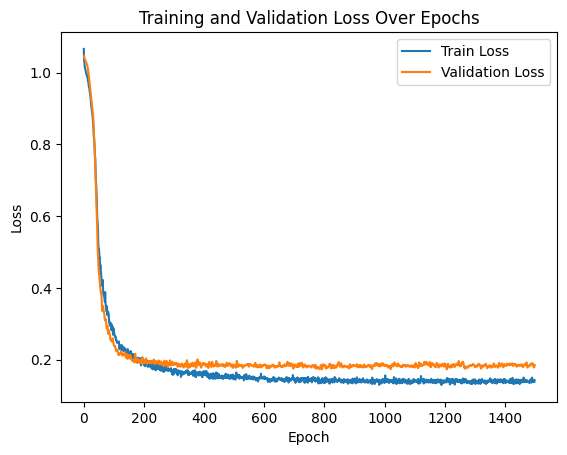

Scaled MSE on train set: 0.0511
Scaled MSE on validation set: 0.1849
Unscaled RMSE on validation set: 230


In [139]:
hidden_config_4 = [512, 256, 128, 64]
model_4 = FlexibleModel(in_features=780, hidden_layers_sizes=hidden_config_4, dropout_prob=0.7)
print("Model 4:")

optimizer_4 = torch.optim.Adam(model_4.parameters(), lr=0.001, weight_decay=0.001)

model_4 = nn.DataParallel(model_4)
model_4.to(device)

num_epochs = 1500
loss_list4 = []
val_loss_list4 = []

for epoch in range(num_epochs):
    model_4.train()

    # Forward pass
    y_pred = model_4(X_train)
    loss = F.mse_loss(y_pred, y_train)

    # Backward + optimize
    optimizer_4.zero_grad()
    loss.backward()
    optimizer_4.step()

    loss_list4.append(loss.item())

    # Validation
    model_4.eval()
    with torch.no_grad():
        val_pred = model_4(X_val)
        val_loss = F.mse_loss(val_pred, y_val)
        val_loss_list4.append(val_loss.item())

plt.plot(loss_list4, label='Train Loss')
plt.plot(val_loss_list4, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

model_4.eval() 
with torch.no_grad():
    # Get scaled predictions
    overall_train_pred_scaled = model_4(X_train)
    overall_val_pred_scaled = model_4(X_val)
    
    # Calculate scaled MSE (0-1 range)
    scaled_mse_train = F.mse_loss(overall_train_pred_scaled, y_train).item()
    scaled_mse_val = F.mse_loss(overall_val_pred_scaled, y_val).item()

    train_pred_unscaled = scaler_y.inverse_transform(overall_train_pred_scaled.detach().cpu().numpy())
    val_pred_unscaled = scaler_y.inverse_transform(overall_val_pred_scaled.detach().cpu().numpy())
    
    # Then inverse transform the true values
    y_train_unscaled = scaler_y.inverse_transform(y_train.detach().cpu().numpy())
    y_val_unscaled = scaler_y.inverse_transform(y_val.detach().cpu().numpy())

    # Now calculate MSE on original scale
    mse_train_unscaled = np.mean((train_pred_unscaled - y_train_unscaled)**2)
    mse_val_unscaled = np.mean((val_pred_unscaled - y_val_unscaled)**2)

    rmse_val_unscaled = np.sqrt(mse_val_unscaled)


print(f"Scaled MSE on train set: {scaled_mse_train:.4f}")  
print(f"Scaled MSE on validation set: {scaled_mse_val:.4f}")  
print(f"Unscaled RMSE on validation set: {rmse_val_unscaled.item():.0f}")

In [141]:
weight_decay_values = [0.0, 0.01, 0.001, 0.005, 0.008]
dropout_prob = [0.3, 0.5, 0.6, 0.7]

results = {}

for do_val in dropout_prob:
    for wd_val in weight_decay_values:
        
        hyperparams_key = f"WD={wd_val}, DO={do_val}"
        print(f"\n--- Training with: {hyperparams_key} ---")
    
        model_4 = FlexibleModel(in_features=780, hidden_layers_sizes=hidden_config_4, dropout_prob=do_val)
    
        optimizer_4 = torch.optim.Adam(model_4.parameters(), lr=0.001, weight_decay=wd_val)
    
        model_4.to(device)
    
        num_epochs = 1500
        loss_list4 = []
        val_loss_list4 = []
        
        for epoch in range(num_epochs):
            model_4.train()
        
            # Forward pass
            y_pred = model_4(X_train)
            loss = F.mse_loss(y_pred, y_train)
        
            # Backward + optimize
            optimizer_4.zero_grad()
            loss.backward()
            optimizer_4.step()
        
            loss_list4.append(loss.item())
        
            # Validation
            model_4.eval()
            with torch.no_grad():
                val_pred = model_4(X_val)
                val_loss = F.mse_loss(val_pred, y_val)
                val_loss_list4.append(val_loss.item())
    
        final_val_loss = val_loss_list4[-1]
        results[hyperparams_key] = final_val_loss
        
        print(f"    Finished. Final Validation MSE: {final_val_loss:.6f}")

print("\n--- Grid Search Complete ---")

best_hyperparams = min(results, key=results.get)
best_loss = results[best_hyperparams]

print(f"\nBest Hyperparameters found: {best_hyperparams}")
print(f"Corresponding final validation MSE: {best_loss:.6f}")


--- Training with: WD=0.0, DO=0.3 ---
    Finished. Final Validation MSE: 0.179869

--- Training with: WD=0.01, DO=0.3 ---
    Finished. Final Validation MSE: 0.189171

--- Training with: WD=0.001, DO=0.3 ---
    Finished. Final Validation MSE: 0.168318

--- Training with: WD=0.005, DO=0.3 ---
    Finished. Final Validation MSE: 0.186349

--- Training with: WD=0.008, DO=0.3 ---
    Finished. Final Validation MSE: 0.165946

--- Training with: WD=0.0, DO=0.5 ---
    Finished. Final Validation MSE: 0.183437

--- Training with: WD=0.01, DO=0.5 ---
    Finished. Final Validation MSE: 0.171899

--- Training with: WD=0.001, DO=0.5 ---
    Finished. Final Validation MSE: 0.172872

--- Training with: WD=0.005, DO=0.5 ---
    Finished. Final Validation MSE: 0.171613

--- Training with: WD=0.008, DO=0.5 ---
    Finished. Final Validation MSE: 0.177142

--- Training with: WD=0.0, DO=0.6 ---
    Finished. Final Validation MSE: 0.182022

--- Training with: WD=0.01, DO=0.6 ---
    Finished. Final Va

# Final testing

In [186]:
trained_models = {
    "Model with hidden_config_nn": model_nn,
    "Model with hidden_config_1": model_1,
    "Model with hidden_config_2": model_2,
    "Model with hidden_config_3": model_3,
    "Model with hidden_config_4": model_4
}

results = {}

In [184]:
X_test = torch.tensor(X_test_scaled, dtype=torch.float32).to(device) 
y_test = torch.tensor(y_test_scaled, dtype=torch.float32).to(device) 

In [187]:
for model_name, model in sorted(trained_models.items()):
    print(f"--- Evaluating {model_name} ---")

    model.eval()

    with torch.no_grad():
        test_pred_scaled = model(X_test)

        scaled_mse_test = F.mse_loss(test_pred_scaled, y_test).item()

        test_pred_unscaled = scaler_y.inverse_transform(test_pred_scaled.detach().cpu().numpy())

        y_test_unscaled = scaler_y.inverse_transform(y_test.detach().cpu().numpy())

        mse_test_unscaled = np.mean((test_pred_unscaled - y_test_unscaled)**2)
        rmse_test_unscaled = np.sqrt(mse_test_unscaled)

        results[model_name] = {
            'scaled_mse': scaled_mse_test,
            'unscaled_rmse': rmse_test_unscaled
        }

        print(f"Scaled MSE on test set: {scaled_mse_test:.4f}")
        print(f"Unscaled RMSE on test set: {rmse_test_unscaled:.0f}\n")

--- Evaluating Model with hidden_config_1 ---
Scaled MSE on test set: 0.1464
Unscaled RMSE on test set: 205

--- Evaluating Model with hidden_config_2 ---
Scaled MSE on test set: 0.1453
Unscaled RMSE on test set: 204

--- Evaluating Model with hidden_config_3 ---
Scaled MSE on test set: 0.1531
Unscaled RMSE on test set: 209

--- Evaluating Model with hidden_config_4 ---
Scaled MSE on test set: 0.1730
Unscaled RMSE on test set: 223

--- Evaluating Model with hidden_config_nn ---
Scaled MSE on test set: 0.1901
Unscaled RMSE on test set: 233



# Conclusion

Models 1, 2, and 3 perform slightly better than the others, with an overall test RMSE suggesting they can provide decent predictions. While further reducing the error proved challenging with the current data and approach, a standard deviation of around ~200 is still acceptable for the platform's use case.

Given that the reach prediction is meant to be a rough estimate (not an exact number), the model’s output could be presented as a range. For example, a prediction of 800 might be displayed as: "Your post has the potential to reach 600–1,000 people on LinkedIn." In this context, the margin of error seems reasonable and aligns with user expectations.

Several steps were omitted in the current implementation but could enhance the model’s performance:

1. Log Transformation: A log transform might have improved results if applied correctly, potentially reducing the final RMSE.
2. Early Stopping: Not implemented, which could have prevented overfitting and optimized training time.
3. DataLoader Utilization: Could accelerate training by improving data pipeline efficiency.
4. Hyperparameter Tuning: Random Search may yield better parameters than Grid Search while being more computationally efficient.
5. Additional Data: As always, more training data would likely improve generalization and predictive power.
6. More Ifs statements: To make the models more reliable in case of badly formated data.

# Knowledge gained

Through this project, the author gained hands-on experience in several areas:
1. OOP: Creating and working with class objects
2. Hardware Acceleration: Utilizing GPU computing to speed up model training
3. Data Structures: Handling and manipulating data using dictionaries
4. NLP Fundamentals: Understanding tokenization and embedding mechanisms
5. Data Type Management: Recognizing and converting between different data formats to fit different models/functions (tensors to numpy arrays etc.)
6. Model Development: Building neural networks and optimizing their performance through hyperparameter tuning
7. Project Execution: Successfully transforming an initial concept into a functional implementation